In [1]:
import tensorflow as tf
import numpy as np

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os
import sys
import math
import pickle

In [3]:
import facenet

In [4]:
np.random.seed(666)

In [5]:
train_dir = "data/dataset/train"
test_dir  = "data/dataset/test"
model_dir = "data/20180402-114759/"

batch_size = 5
image_size = 160

LOG_DIR = 'tboard'

In [6]:
def embed(g, sess, data_dir):
    dataset = facenet.get_dataset(data_dir)
    paths, labels = facenet.get_image_paths_and_labels(dataset)
    # Restoe model
    facenet.load_model(model_dir)
    # Get input and output tensors
    images_placeholder = g.get_tensor_by_name("input:0")
    embeddings = g.get_tensor_by_name("embeddings:0")
    phase_train_placeholder = g.get_tensor_by_name("phase_train:0")
    embedding_size = embeddings.get_shape()[1]

    # Run forward pass to calculate embeddings
    nrof_images = len(paths)
    nrof_batches_per_epoch = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches_per_epoch):
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)

        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)
    return emb_array, labels, dataset

In [7]:
g = tf.Graph()

In [8]:
with g.as_default():
    with tf.Session() as sess:
        emb_array, labels, trainset = embed(g, sess, train_dir)

Model directory: data/20180402-114759/
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from data/20180402-114759/model-20180402-114759.ckpt-275


In [9]:
with g.as_default():
    with tf.Session() as sess:
        test_emb_array, test_labels, testset = embed(g, sess, test_dir)

Model directory: data/20180402-114759/
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from data/20180402-114759/model-20180402-114759.ckpt-275


## Face Recognition

In [10]:
emb_size = emb_array.shape[1]
num_classes  = max(labels)+1
hidden1_size = 256

# Hyperparamters
learning_rate = 0.001
max_steps = 200

In [11]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

def nn_layer(input_tensor, input_dim, output_dim, layer_name, activation=tf.nn.relu):
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases

        activations = activation(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations

## Define Network

In [12]:
# Input placeholders
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, emb_size], name='x-input')
    y_true = tf.placeholder(tf.int64, [None], name='y-input')

hidden1 = nn_layer(x, emb_size, hidden1_size, 'layer1')
y = nn_layer(hidden1, hidden1_size, num_classes, 'layer2', activation=tf.identity)

with tf.name_scope('cross_entropy'):
    with tf.name_scope('total'):
        cross_entropy = tf.losses.sparse_softmax_cross_entropy(
            labels=y_true, logits=y)
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(
        cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), y_true)
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

## Train Face Recognizer

In [13]:
def feed_dict(train):
    if train: 
        xs, ys = emb_array, labels
    else:
        xs, ys = test_emb_array, test_labels
    return {x: xs, y_true: ys}

In [14]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as sess:
    # Merge all the summaries and write them out
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(LOG_DIR + '/test')
    tf.global_variables_initializer().run()

    for i in range(max_steps):
        if i % 10 == 0:  # Record summaries and test-set accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Accuracy at step %s: %s' % (i, acc))
        else:  # Record train set summaries, and train
            if i % 50 == 49:  # Record execution stats
                #run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                #run_metadata = tf.RunMetadata()
                summary, _ = sess.run([merged, train_step],
                                      feed_dict=feed_dict(True))#,
                                      #options=run_options,
                                      #run_metadata=run_metadata)
                #train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
                train_writer.add_summary(summary, i)
                print('Adding run metadata for', i)
            else:  # Record a summary
                summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                train_writer.add_summary(summary, i)
    # Save the variables to disk.
    save_path = saver.save(sess, "./faceRecog.ckpt")
    print("Model saved in path: %s" % save_path)
                
train_writer.close()
test_writer.close()


Accuracy at step 0: 0.26984128
Accuracy at step 10: 1.0
Accuracy at step 20: 1.0
Accuracy at step 30: 1.0
Accuracy at step 40: 1.0
Adding run metadata for 49
Accuracy at step 50: 1.0
Accuracy at step 60: 1.0
Accuracy at step 70: 1.0
Accuracy at step 80: 1.0
Accuracy at step 90: 1.0
Adding run metadata for 99
Accuracy at step 100: 1.0
Accuracy at step 110: 1.0
Accuracy at step 120: 1.0
Accuracy at step 130: 1.0
Accuracy at step 140: 1.0
Adding run metadata for 149
Accuracy at step 150: 1.0
Accuracy at step 160: 1.0
Accuracy at step 170: 1.0
Accuracy at step 180: 1.0
Accuracy at step 190: 1.0
Adding run metadata for 199
Model saved in path: ./faceRecog.ckpt


In [15]:
emb_array.shape

(30, 512)

## Deployment

In [16]:
def load_img(img, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    if img.ndim == 2:
        img = facenet.to_rgb(img)
    if do_prewhiten:
        img = facenet.prewhiten(img)
    img = facenet.crop(img, do_random_crop, image_size)
    img = facenet.flip(img, do_random_flip)
    return [img]

In [17]:
def embed_one(g, sess, img):
    # Restoe model
    facenet.load_model(model_dir)
    # Get input and output tensors
    images_placeholder = g.get_tensor_by_name("input:0")
    embeddings = g.get_tensor_by_name("embeddings:0")
    phase_train_placeholder = g.get_tensor_by_name("phase_train:0")
    embedding_size = embeddings.get_shape()[1]

    # Run forward pass to calculate embeddings
    emb_array = np.zeros((embedding_size))

    image = load_img(img, False, False, image_size)
    feed_dict = { images_placeholder:image, phase_train_placeholder:False }
    emb_array = sess.run(embeddings, feed_dict=feed_dict)
    
    return emb_array

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


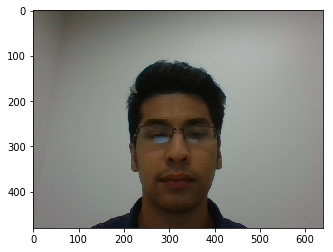

In [26]:
%pylab
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
cap = cv2.VideoCapture(0)
for _ in range(8):
    time.sleep(0.1)
    ret,frame = cap.read()
    frame = frame[...,::-1]
cap.release()
plt.imshow(frame)
plt.show()

In [27]:
with g.as_default():
    with tf.Session() as sess:
        selfie_embed = embed_one(g, sess, frame)

Model directory: data/20180402-114759/
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from data/20180402-114759/model-20180402-114759.ckpt-275


In [28]:
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./faceRecog.ckpt")
    person_vec = sess.run(y, feed_dict={x: selfie_embed})

INFO:tensorflow:Restoring parameters from ./faceRecog.ckpt


In [29]:
class_names = [ cls.name.replace('_', ' ') for cls in testset]
best_class_indices = np.argmax(person_vec, axis=1)

In [30]:
class_names[best_class_indices[0]]

'abay b'

In [31]:
person_vec

array([[ 2.025644 , -0.6086541, -0.2938079]], dtype=float32)